# Defacing pre-registration - Statistical analysis in R

In [103]:
# Helper function to diagnose linear mixed-effects model fit
visualize_lmer_fit <- function(model, defaced=FALSE){
    # Install and load necessary packages
    library(lme4)
    library(ggplot2)
    library(gridExtra)

    #Plot size
    options(repr.plot.width=20, repr.plot.height=10)

    # Extract residuals and fitted values
    residuals <- residuals(model)
    fitted_values <- fitted(model)

    # Extract random effects
    random_effects_list <- ranef(model)

    # Residuals vs Fitted Values plot
    residuals_plot <- ggplot(data = data.frame(Fitted = fitted_values, Residuals = residuals),
                            aes(x = Fitted, y = Residuals)) +
        geom_point() +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        theme(text = element_text(size = 36))+
        theme_minimal() +
        labs(title = "Residuals vs Fitted Values",
            x = "Fitted Values",
            y = "Residuals")
    

    # QQ plot of residuals
    qq_plot_residuals <- ggqqplot(residuals) +
        theme(text = element_text(size = 36))+
        theme_minimal() +
        labs(title = "Residuals vs Fitted Values",
            x = "Fitted Values",
            y = "Residuals")

    # List to store QQ plots for random effects
    qq_plots_random_effects <- list()
    
    # Generate QQ plots for each random effect
    for (re in names(random_effects_list)) {
        random_effects <- unlist(random_effects_list[[re]])
        qq_plot <- ggqqplot(random_effects) +
            theme(text = element_text(size = 36))+
            theme_minimal() +
            labs(title = paste("QQ Plot of Random Effects:", re),
                x = "Theoretical Quantiles",
                y = "Sample Quantiles")
            qq_plots_random_effects[[re]] <- qq_plot
    }
  
    # Combine all plots into a single figure
    combined_plots <- list(residuals_plot, qq_plot_residuals)
    combined_plots <- c(combined_plots, qq_plots_random_effects)
    combined_plot <- do.call(grid.arrange, c(combined_plots, ncol = 2))

    # Print the combined plot
    print(combined_plot)
}


## Load the simulated or collected manual ratings

In [104]:
df <- read.csv(file = '../../data/IXI_augmented_ratings_df.tsv', sep='\t')
# Drop columns we will not use in the analysis
df <- df[, !names(df) %in% c("dataset", "artifacts", "time_sec", "confidence", "comments", "randomized_id")]
# sort dataframe by subject ID
df <- df[order(df$subject),]
df

,rater_id,rating,defaced,subject
,<chr>,<dbl>,<int>,<int>
49,rater_03,3.45,0,12
100,rater_01,3.40,0,12
134,rater_04,3.50,0,12
192,rater_02,3.65,0,12
787,rater_04,3.90,1,12
1038,rater_02,3.50,1,12
1410,rater_03,2.75,1,12
1659,rater_01,3.40,1,12
180,rater_04,3.45,0,13


In [105]:
library(dplyr)
# When there are two ratings corresponding to one image, keep first rating only, as rm-ANOVA is not able to deal with duplicates
df_nodup <- df[!duplicated(df[c("subject", "defaced", "rater_id")]), ]
nrow(df_nodup)

[1] 1480

## Linear mixed-effects models

We will test if including the defacing factor as fixed effect improves the model fit using a likelihood-ratio test.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: as.numeric(rating) ~ (1 | subject) + (1 | rater_id)
   Data: df_nodup

     AIC      BIC   logLik deviance df.resid 
  1546.8   1568.0   -769.4   1538.8     1476 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3693 -0.5709  0.0442  0.6422  3.4396 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.14729  0.3838  
 rater_id (Intercept) 0.04958  0.2227  
 Residual             0.12169  0.3488  
Number of obs: 1480, groups:  subject, 185; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)   3.1242     0.1152   27.12

$subject
      (Intercept)
12   0.2896467575
13  -0.0899040998
14  -0.1975379250
15  -0.2655171830
33   0.1480233033
34   0.0743791071
39   0.2386623140
48  -0.1862080487
49   0.2386623140
51   0.3576260155
52   0.3066415720
56   0.1763479941
57   0.3123065102
59   0.2273324377
67   0.0800440453
72  -0.6450680403
79   0.0290596017
80   0.0743791071
83   0.1706830560
92   0.2160025613
93   0.1480233033
94  -0.4241354518
95   0.3236363865
96   0.2783168812
97  -0.0105949654
102 -0.0615794090
104  0.0630492308
105  0.0290596017
126  0.4652598407
127  0.0743791071
128  0.1933428086
130  0.0007349109
131  0.0403894781
132  0.1366934269
136  0.0800440453
137  0.1310284888
146  0.1140336743
148  0.2499921903
150  0.1933428086
159  0.2160025613
160  0.2103376231
161  0.2386623140
162  0.1876778705
163  0.2216674995
165  0.1083687361
167 -0.2768470594
168 -0.0785742235
173 -0.0105949654
174  0.0177297254
175 -1.1039280320
176  0.0970388598
180  0.3009766338
195  0.1820129323
201 -0.0502495326
2

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


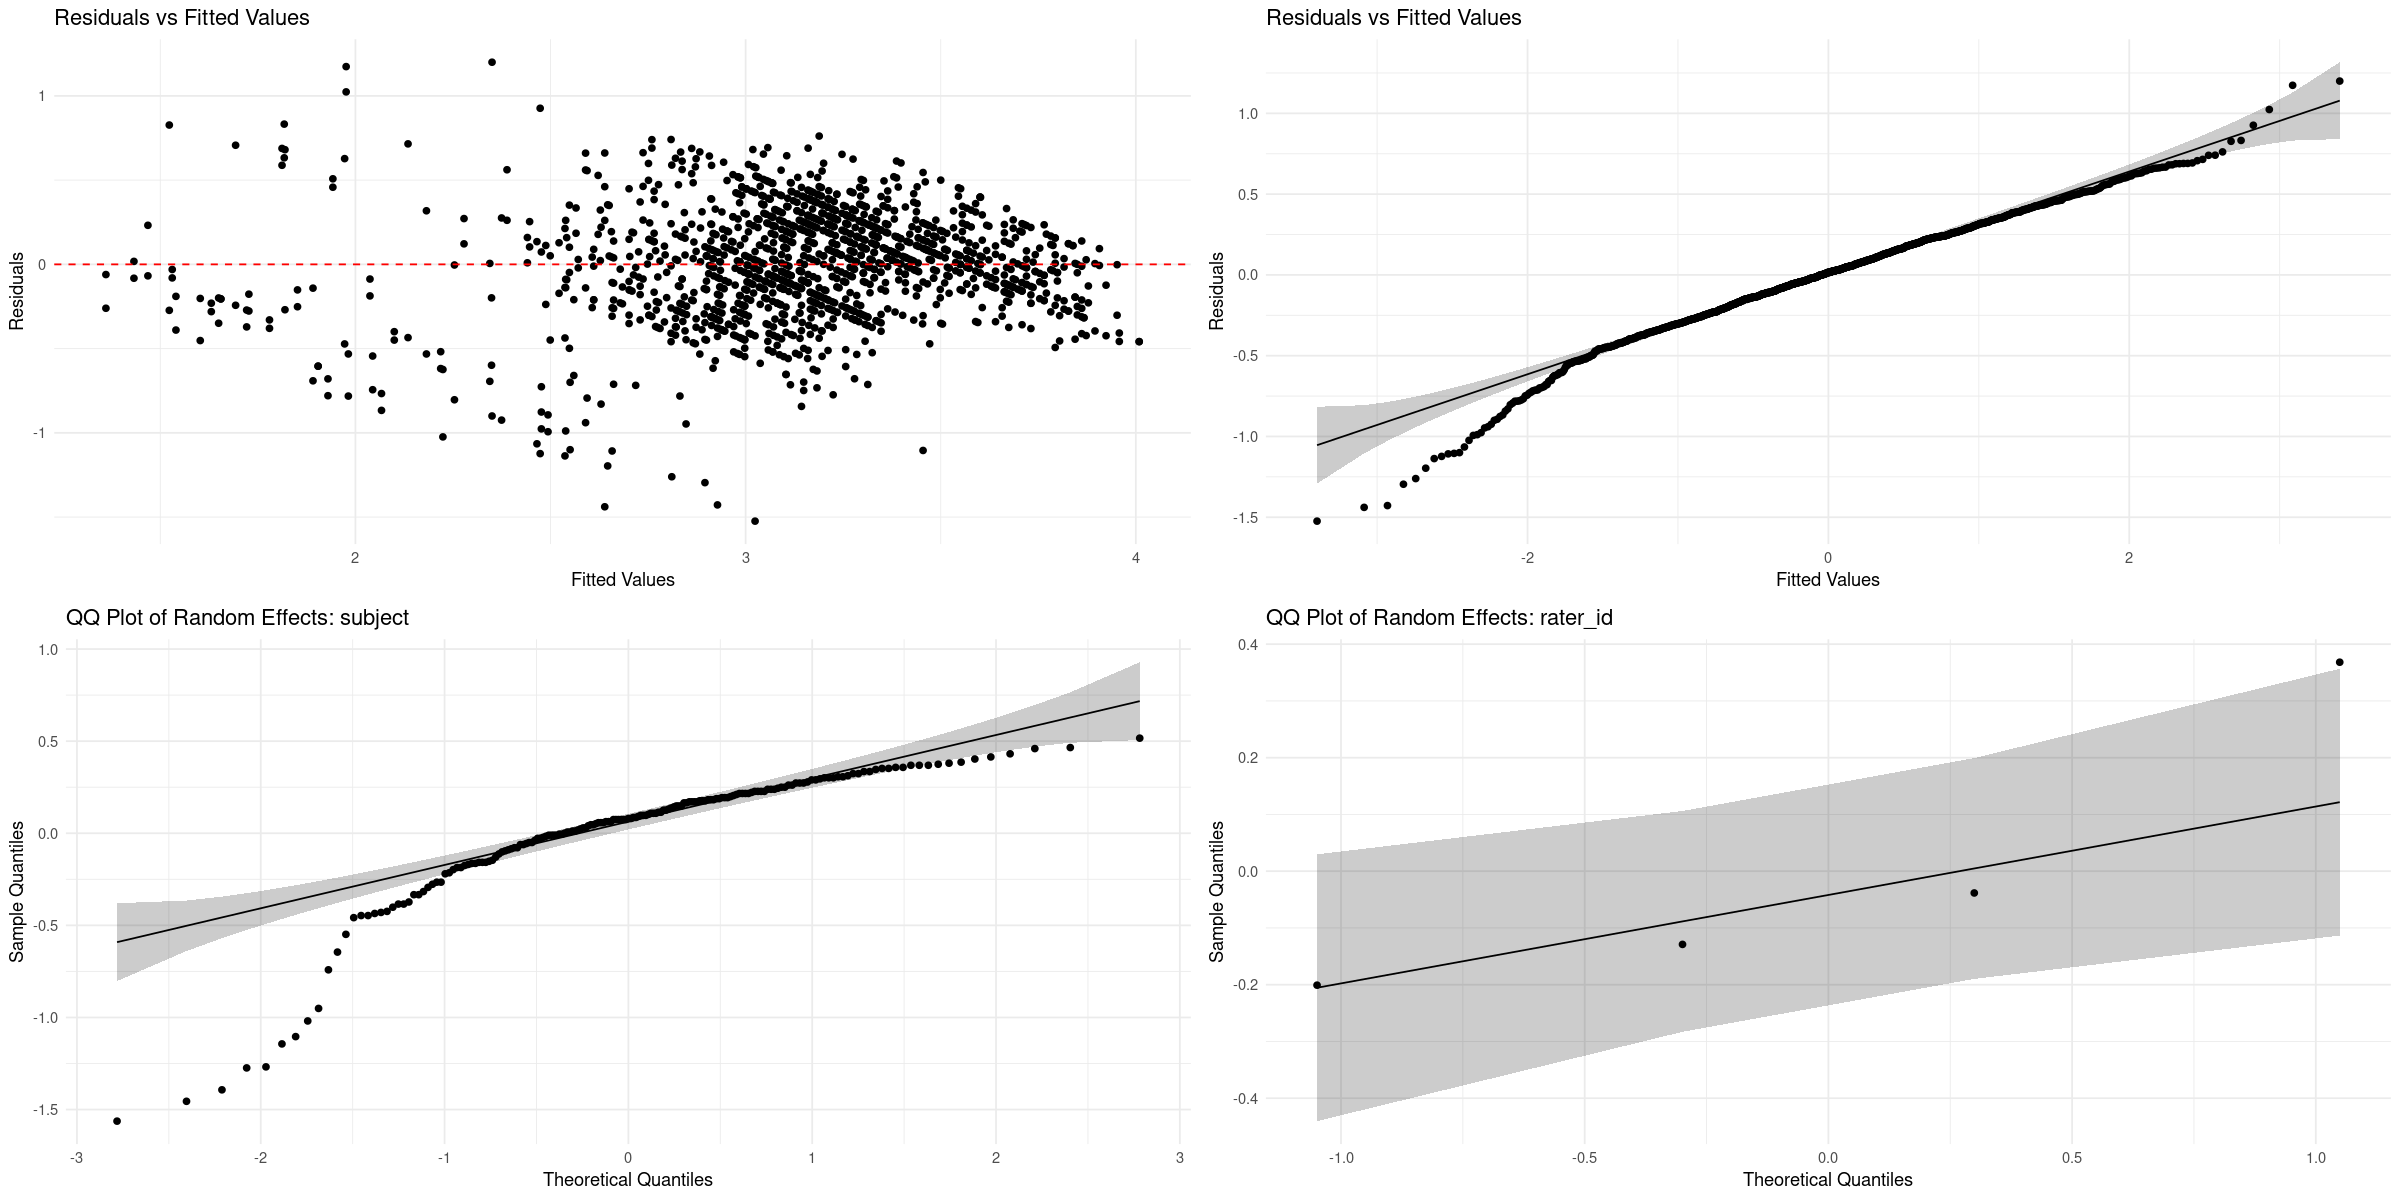

In [106]:
## Fit model without including defaced
library(lme4)
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=df_nodup, REML=FALSE)
summary(fm0)
ranef(fm0)
suppressWarnings(visualize_lmer_fit(fm0))


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: 
as.numeric(rating) ~ (1 | subject) + (1 | rater_id) + (1 | defaced:rater_id)
   Data: df_nodup

     AIC      BIC   logLik deviance df.resid 
  1546.1   1572.6   -768.1   1536.1     1475 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4683 -0.5750  0.0285  0.6399  3.3943 

Random effects:
 Groups           Name        Variance Std.Dev.
 subject          (Intercept) 0.147366 0.38388 
 defaced:rater_id (Intercept) 0.001072 0.03274 
 rater_id         (Intercept) 0.049033 0.22143 
 Residual                     0.121080 0.34797 
Number of obs: 1480, groups:  subject, 185; defaced:rater_id, 8; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)   3.1242     0.1152   27.12

$subject
      (Intercept)
12   0.2897975448
13  -0.0899509030
14  -0.1976407614
15  -0.2656554087
33   0.1481003628
34   0.0744178281
39   0.2387865593
48  -0.1863049868
49   0.2387865593
51   0.3578121922
52   0.3068012067
56   0.1764397992
57   0.3124690940
59   0.2274507847
67   0.0800857154
72  -0.6454038566
79   0.0290747299
80   0.0744178281
83   0.1707719119
92   0.2161150102
93   0.1481003628
94  -0.4243562526
95   0.3238048685
96   0.2784617703
97  -0.0106004811
102 -0.0616114666
104  0.0630820536
105  0.0290747299
126  0.4655020506
127  0.0744178281
128  0.1934434611
130  0.0007352935
131  0.0404105045
132  0.1367645882
136  0.0800857154
137  0.1310967010
146  0.1140930391
148  0.2501223339
150  0.1934434611
159  0.2161150102
160  0.2104471229
161  0.2387865593
162  0.1877755738
163  0.2217828975
165  0.1084251518
167 -0.2769911833
168 -0.0786151285
173 -0.0106004811
174  0.0177389553
175 -1.1045027264
176  0.0970893773
180  0.3011333194
195  0.1821076865
201 -0.0502756920
2

TableGrob (3 x 2) "arrange": 5 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]


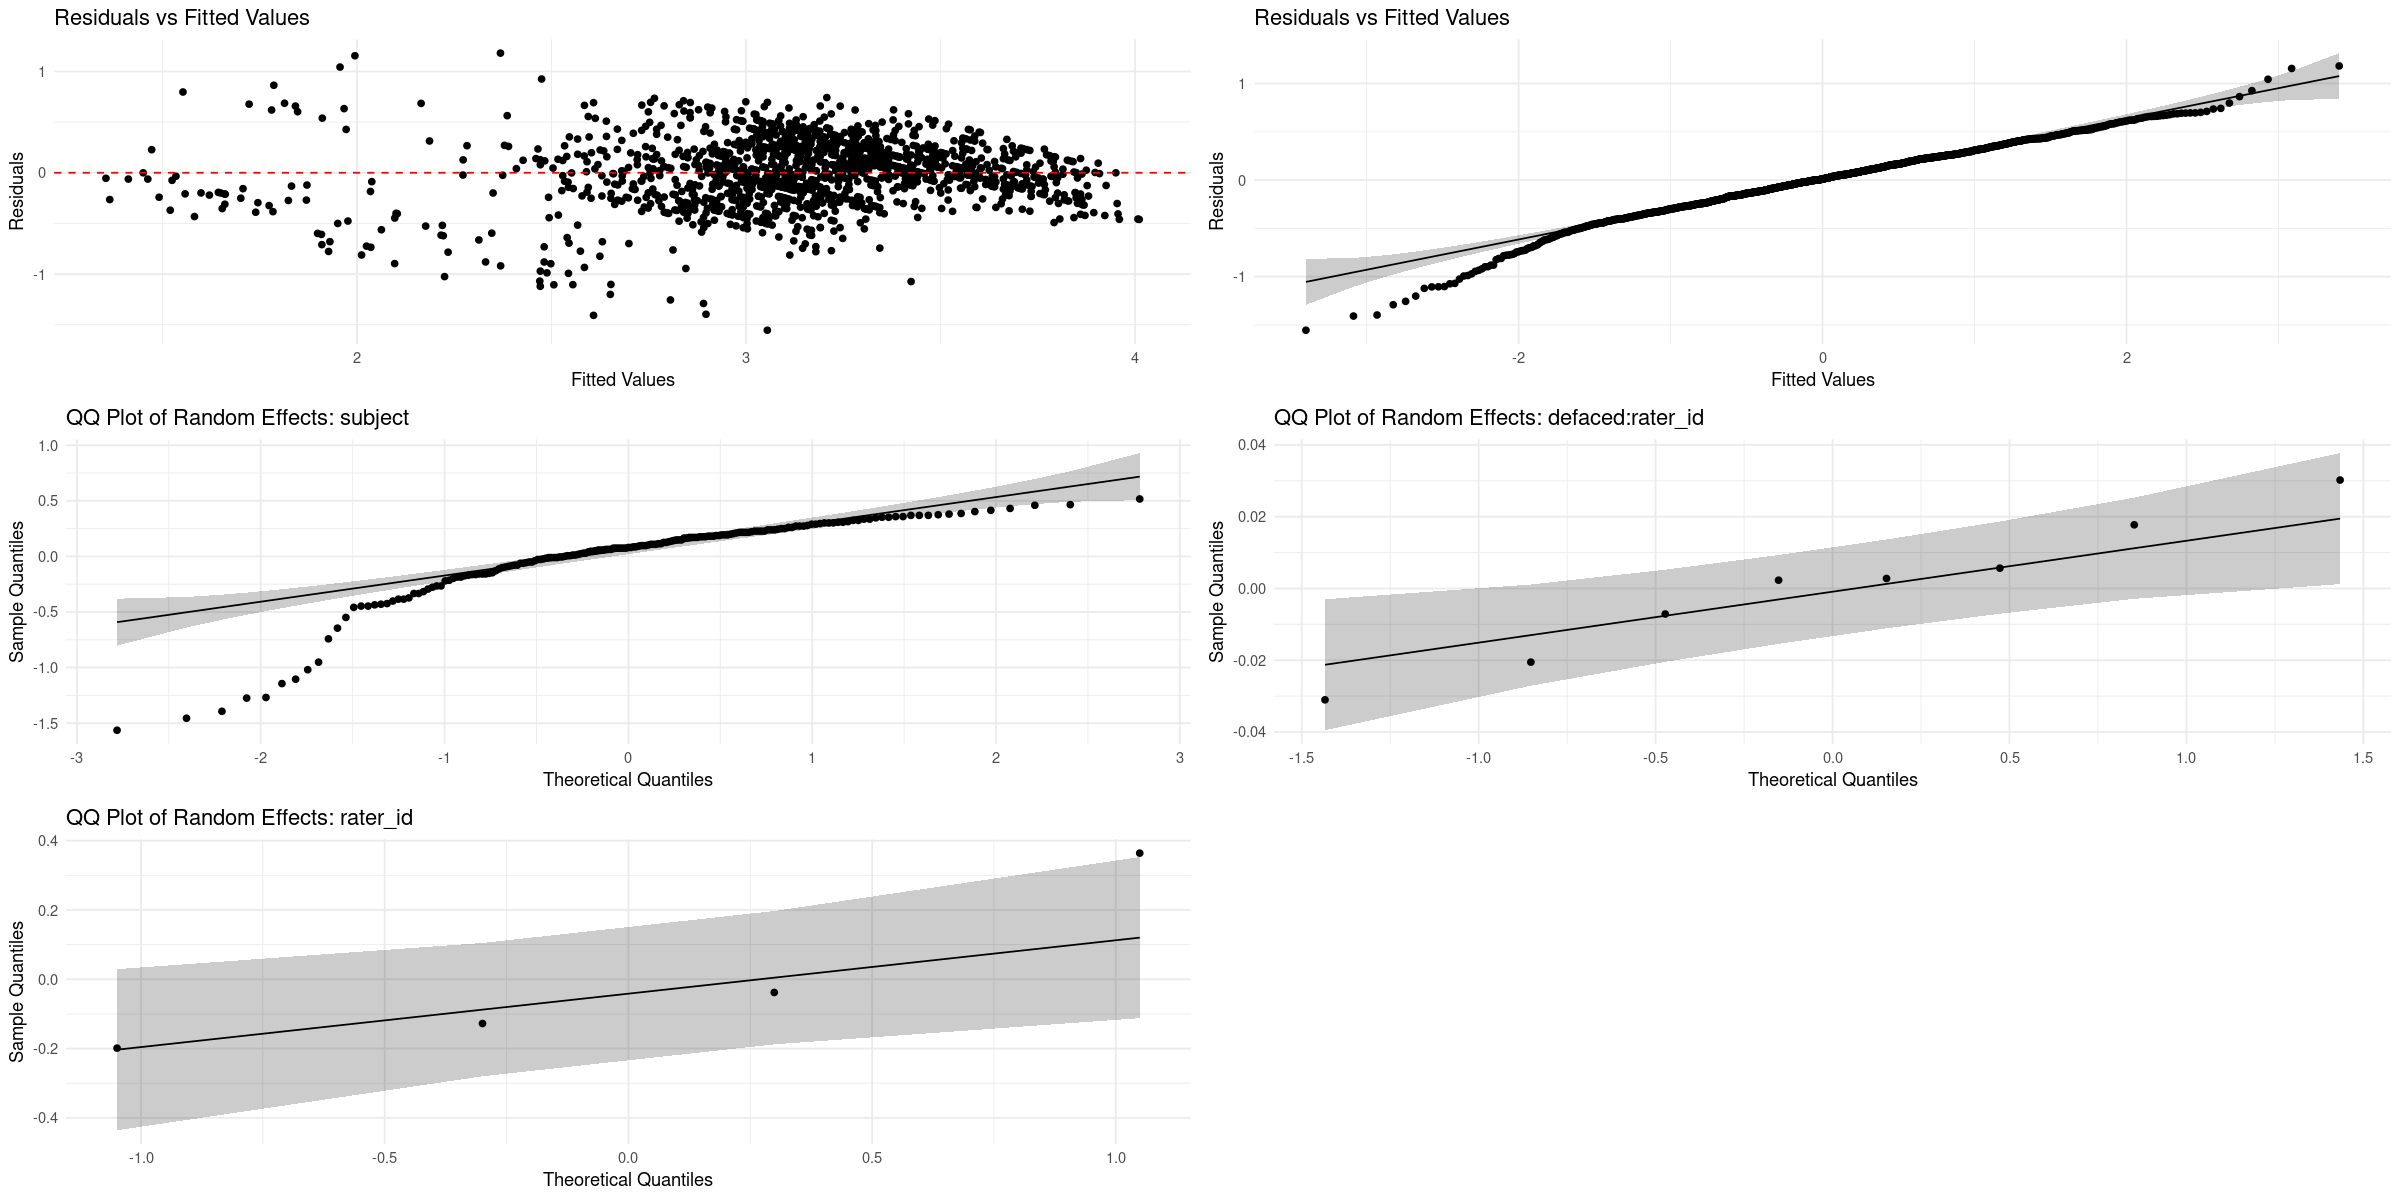

In [107]:
## Fit model including defaced
fm1 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id) + (1 | defaced:rater_id), data=df_nodup, REML=FALSE)
summary(fm1)
ranef(fm1)
suppressWarnings(visualize_lmer_fit(fm1))

In [108]:
#Likelihood-ratio test
anova(fm0, fm1)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,1546.788,1567.987,-769.3938,1538.788,NA,NA,NA
fm1,5,1546.132,1572.631,-768.0661,1536.132,2.655374,1,0.1032005


The p-value for the likelihood-ratio test is significant (3e-8) meaning that defacing influence on the manual ratings is significant.

## Exploratory analysis


### Linear mixed-effects without rater_04

In [109]:
#Remove rater_04
df_nodup_w04 <- df_nodup %>%
  filter(rater_id != "rater_04")
nrow(df_nodup_w04)

[1] 1110

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: as.numeric(rating) ~ (1 | subject) + (1 | rater_id)
   Data: df_nodup_w04

     AIC      BIC   logLik deviance df.resid 
  1326.1   1346.2   -659.1   1318.1     1106 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8200 -0.5850  0.0382  0.6406  3.1009 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.156950 0.39617 
 rater_id (Intercept) 0.004675 0.06837 
 Residual             0.135069 0.36752 
Number of obs: 1110, groups:  subject, 185; rater_id, 3

Fixed effects:
            Estimate Std. Error t value
(Intercept)  3.00063    0.05028   59.67

$subject
     (Intercept)
12   0.312832703
13  -0.051567562
14  -0.219191684
15  -0.350375779
33   0.203512624
34   0.065040523
39   0.239952650
48  -0.139023626
49   0.320120709
51   0.400288767
52   0.320120709
56   0.145208581
57   0.422152783
59   0.196224618
67   0.065040523
72  -0.437831843
79   0.057752518
80   0.006736481
83   0.167072597
92   0.232664645
93   0.159784592
94  -0.561727933
95   0.356560735
96   0.276392677
97  -0.051567562
102 -0.175463652
104  0.035888502
105  0.043176507
126  0.589776905
127  0.043176507
128  0.123344565
130 -0.015127535
131 -0.036991551
132  0.167072597
136  0.072328528
137  0.094192544
146  0.145208581
148  0.247240656
150  0.225376640
159  0.254528661
160  0.203512624
161  0.290968687
162  0.174360603
163  0.188936613
165  0.116056560
167 -0.364951790
168 -0.117159610
173 -0.051567562
174  0.021312491
175 -1.217648411
176  0.167072597
180  0.269104672
195  0.232664645
201 -0.073431578
202  0.057752518
204 -1.341544501
205  0.261816666
206 -

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


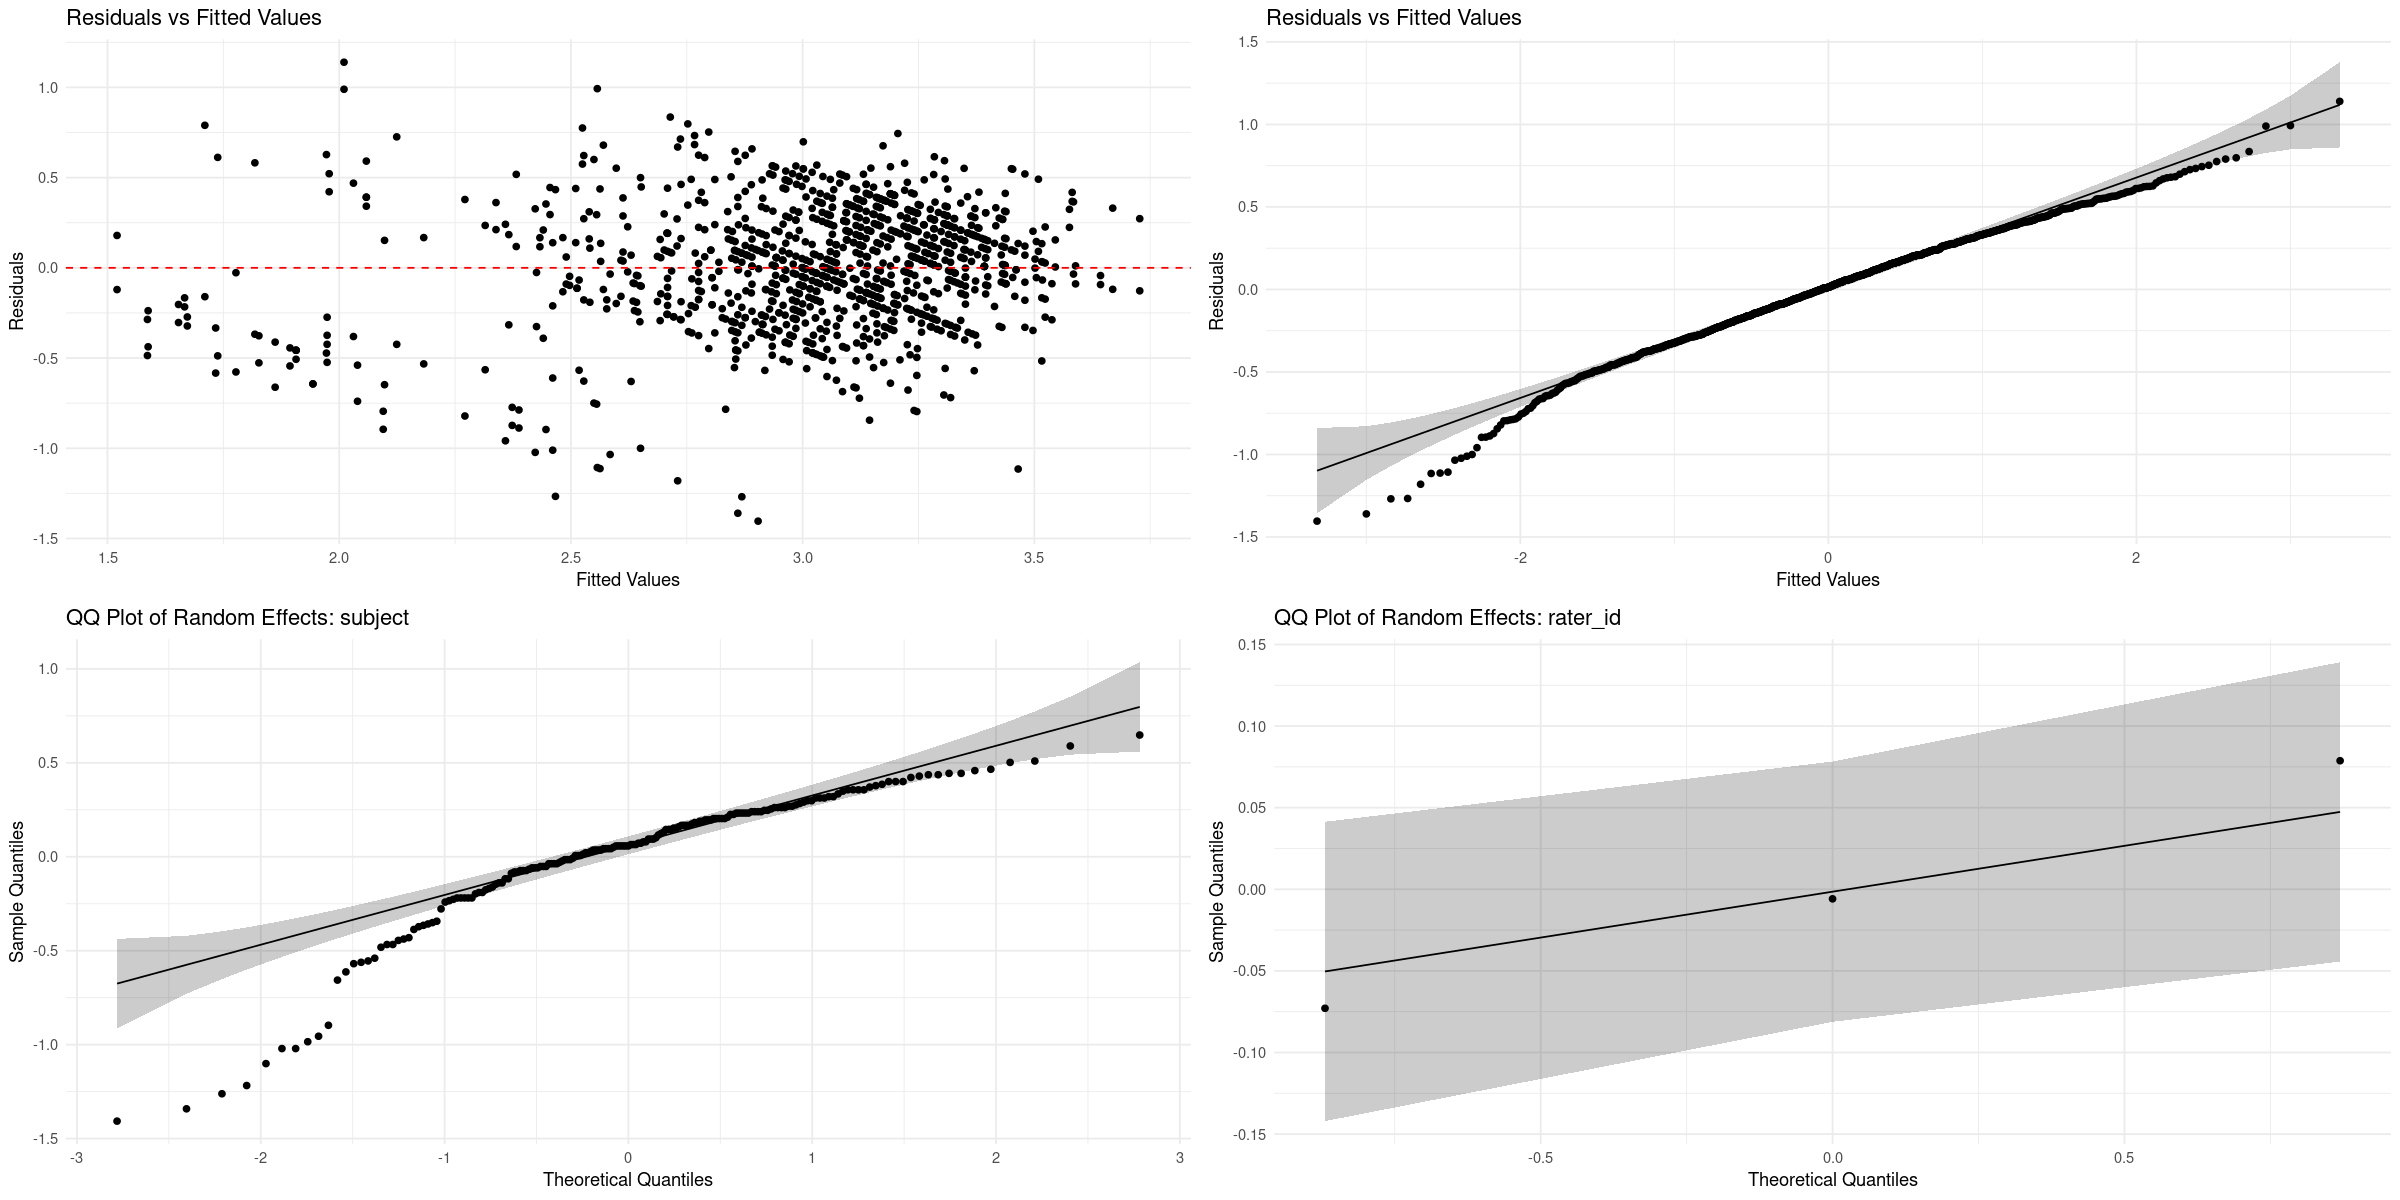

In [110]:
## Fit model without including defaced
library(lme4)
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=df_nodup_w04, REML=FALSE)
summary(fm0)
ranef(fm0)
suppressWarnings(visualize_lmer_fit(fm0))


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: 
as.numeric(rating) ~ (1 | subject) + (1 | rater_id) + (1 | defaced:rater_id)
   Data: df_nodup_w04

     AIC      BIC   logLik deviance df.resid 
  1325.1   1350.2   -657.5   1315.1     1105 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9253 -0.5719  0.0498  0.6557  3.0570 

Random effects:
 Groups           Name        Variance Std.Dev.
 subject          (Intercept) 0.157108 0.39637 
 defaced:rater_id (Intercept) 0.001572 0.03965 
 rater_id         (Intercept) 0.003891 0.06238 
 Residual                     0.134124 0.36623 
Number of obs: 1110, groups:  subject, 185; defaced:rater_id, 6; rater_id, 3

Fixed effects:
            Estimate Std. Error t value
(Intercept)  3.00063    0.05029   59.66

$subject
     (Intercept)
12   0.313146918
13  -0.051619357
14  -0.219411844
15  -0.350727703
33   0.203717036
34   0.065105851
39   0.240193663
48  -0.139163263
49   0.320442244
51   0.400690825
52   0.320442244
56   0.145354432
57   0.422576801
59   0.196421710
67   0.065105851
72  -0.438271610
79   0.057810525
80   0.006743247
83   0.167240408
92   0.232898338
93   0.159945083
94  -0.562292143
95   0.356918872
96   0.276670291
97  -0.051619357
102 -0.175639891
104  0.035924549
105  0.043219874
126  0.590369288
127  0.043219874
128  0.123468455
130 -0.015142730
131 -0.037028706
132  0.167240408
136  0.072401176
137  0.094287153
146  0.145354432
148  0.247488989
150  0.225603012
159  0.254784314
160  0.203717036
161  0.291260942
162  0.174535734
163  0.189126385
165  0.116173130
167 -0.365318354
168 -0.117277287
173 -0.051619357
174  0.021333898
175 -1.218871440
176  0.167240408
180  0.269374965
195  0.232898338
201 -0.073505334
202  0.057810525
204 -1.342891973
205  0.262079640
206 -

TableGrob (3 x 2) "arrange": 5 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]


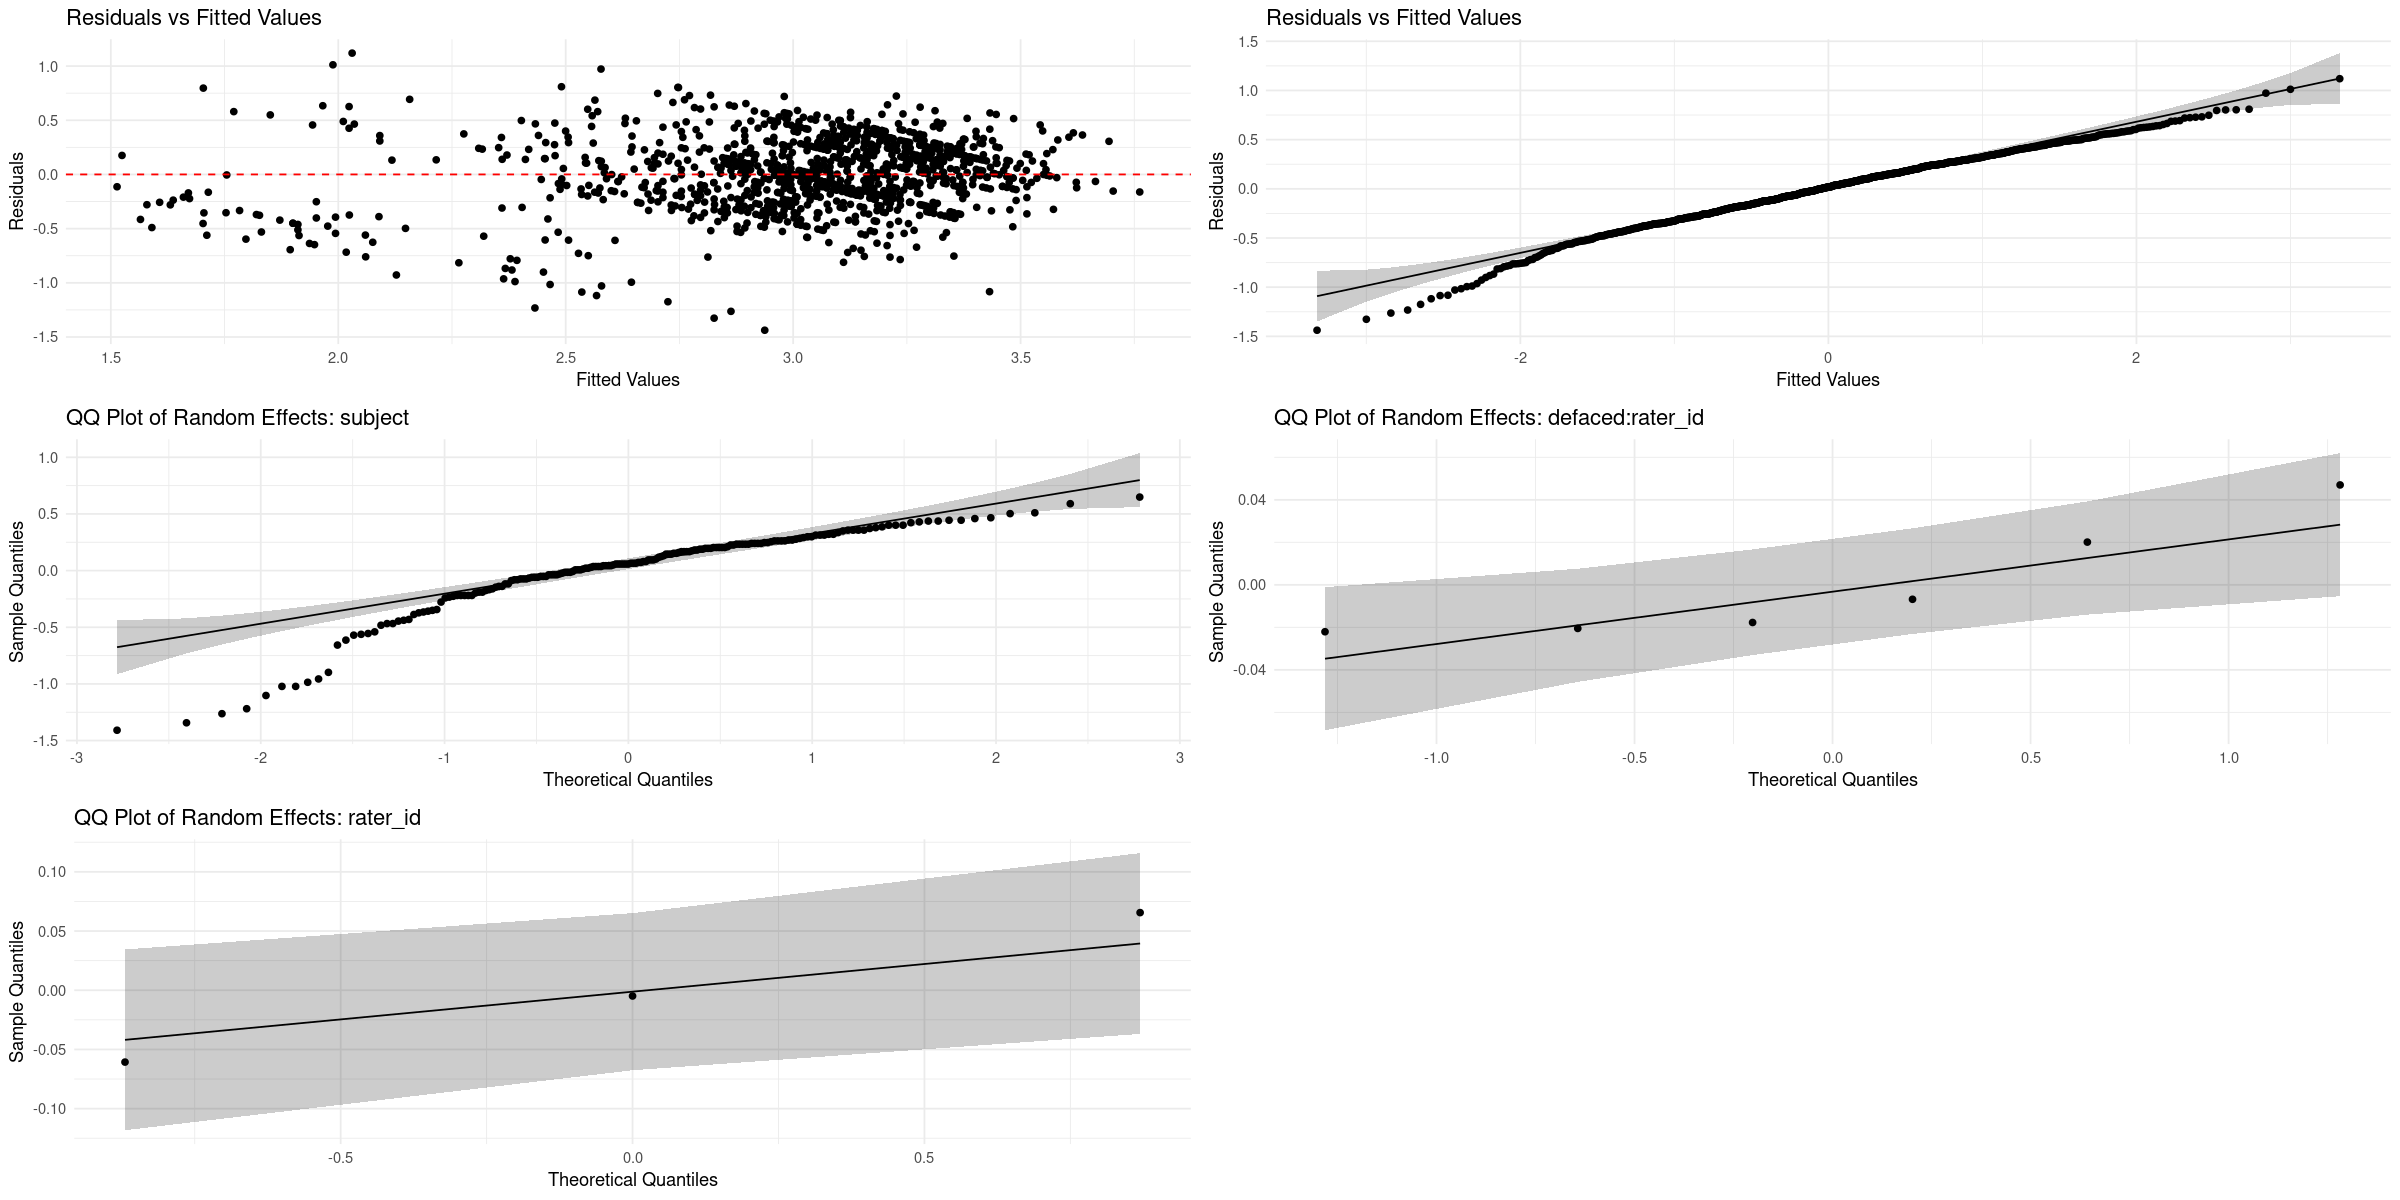

In [111]:
## Fit model including defaced
fm1 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id) + (1 | defaced:rater_id), data=df_nodup_w04, REML=FALSE)
summary(fm1)
ranef(fm1)
suppressWarnings(visualize_lmer_fit(fm1))

In [112]:
#Likelihood-ratio test
anova(fm0, fm1)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,1326.116,1346.164,-659.0578,1318.116,NA,NA,NA
fm1,5,1325.093,1350.153,-657.5463,1315.093,3.022995,1,0.08209173


### Linear mixed-effects with only poor quality and excluded scans

In [113]:
library(dplyr)
df_poor <- df %>%
  filter(rating <= 2.45)
nrow(df_poor)

[1] 186

Linear mixed model fit by REML ['lmerMod']
Formula: as.numeric(rating) ~ (1 | subject) + (1 | rater_id)
   Data: df_poor

REML criterion at convergence: 193.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2169 -0.6559  0.1103  0.5891  2.3674 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.10563  0.3250  
 rater_id (Intercept) 0.01268  0.1126  
 Residual             0.10662  0.3265  
Number of obs: 186, groups:  subject, 63; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.09352    0.07723   27.11

$subject
    (Intercept)
15   0.28756476
34   0.18979364
48   0.20360828
72   0.10524404
80   0.24176356
94   0.14680293
102 -0.34478101
104  0.12800219
105  0.10311886
146  0.24176356
165  0.18979364
167 -0.19367412
168  0.24176356
175 -0.55530908
176  0.12800219
204 -0.61581808
206  0.17896453
212  0.12800219
216  0.18979364
226 -0.51037239
252 -0.40107992
256  0.12800219
257 -0.28075026
258 -0.15636965
261  0.03090308
267  0.24176356
274  0.26906753
277  0.09097603
282  0.24176356
295 -0.21126577
313  0.25345247
316 -0.41268405
329 -0.05217057
338  0.24302180
353  0.09337264
357  0.24176356
383 -0.05025006
384  0.16491032
385  0.18979364
386  0.16491032
387 -0.42516941
437  0.24176356
443 -0.12935554
448 -0.66769591
481 -0.18125298
482 -0.34478101
524 -0.33159868
525  0.12800219
538  0.17614317
544  0.26581563
565  0.24176356
568  0.16491032
577 -0.20513488
598  0.05664655
599 -0.20881772
603  0.24302180
605 -0.27527664
612  0.10311886
632  0.05335221
633  0.07823554
634 -0.04414155

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


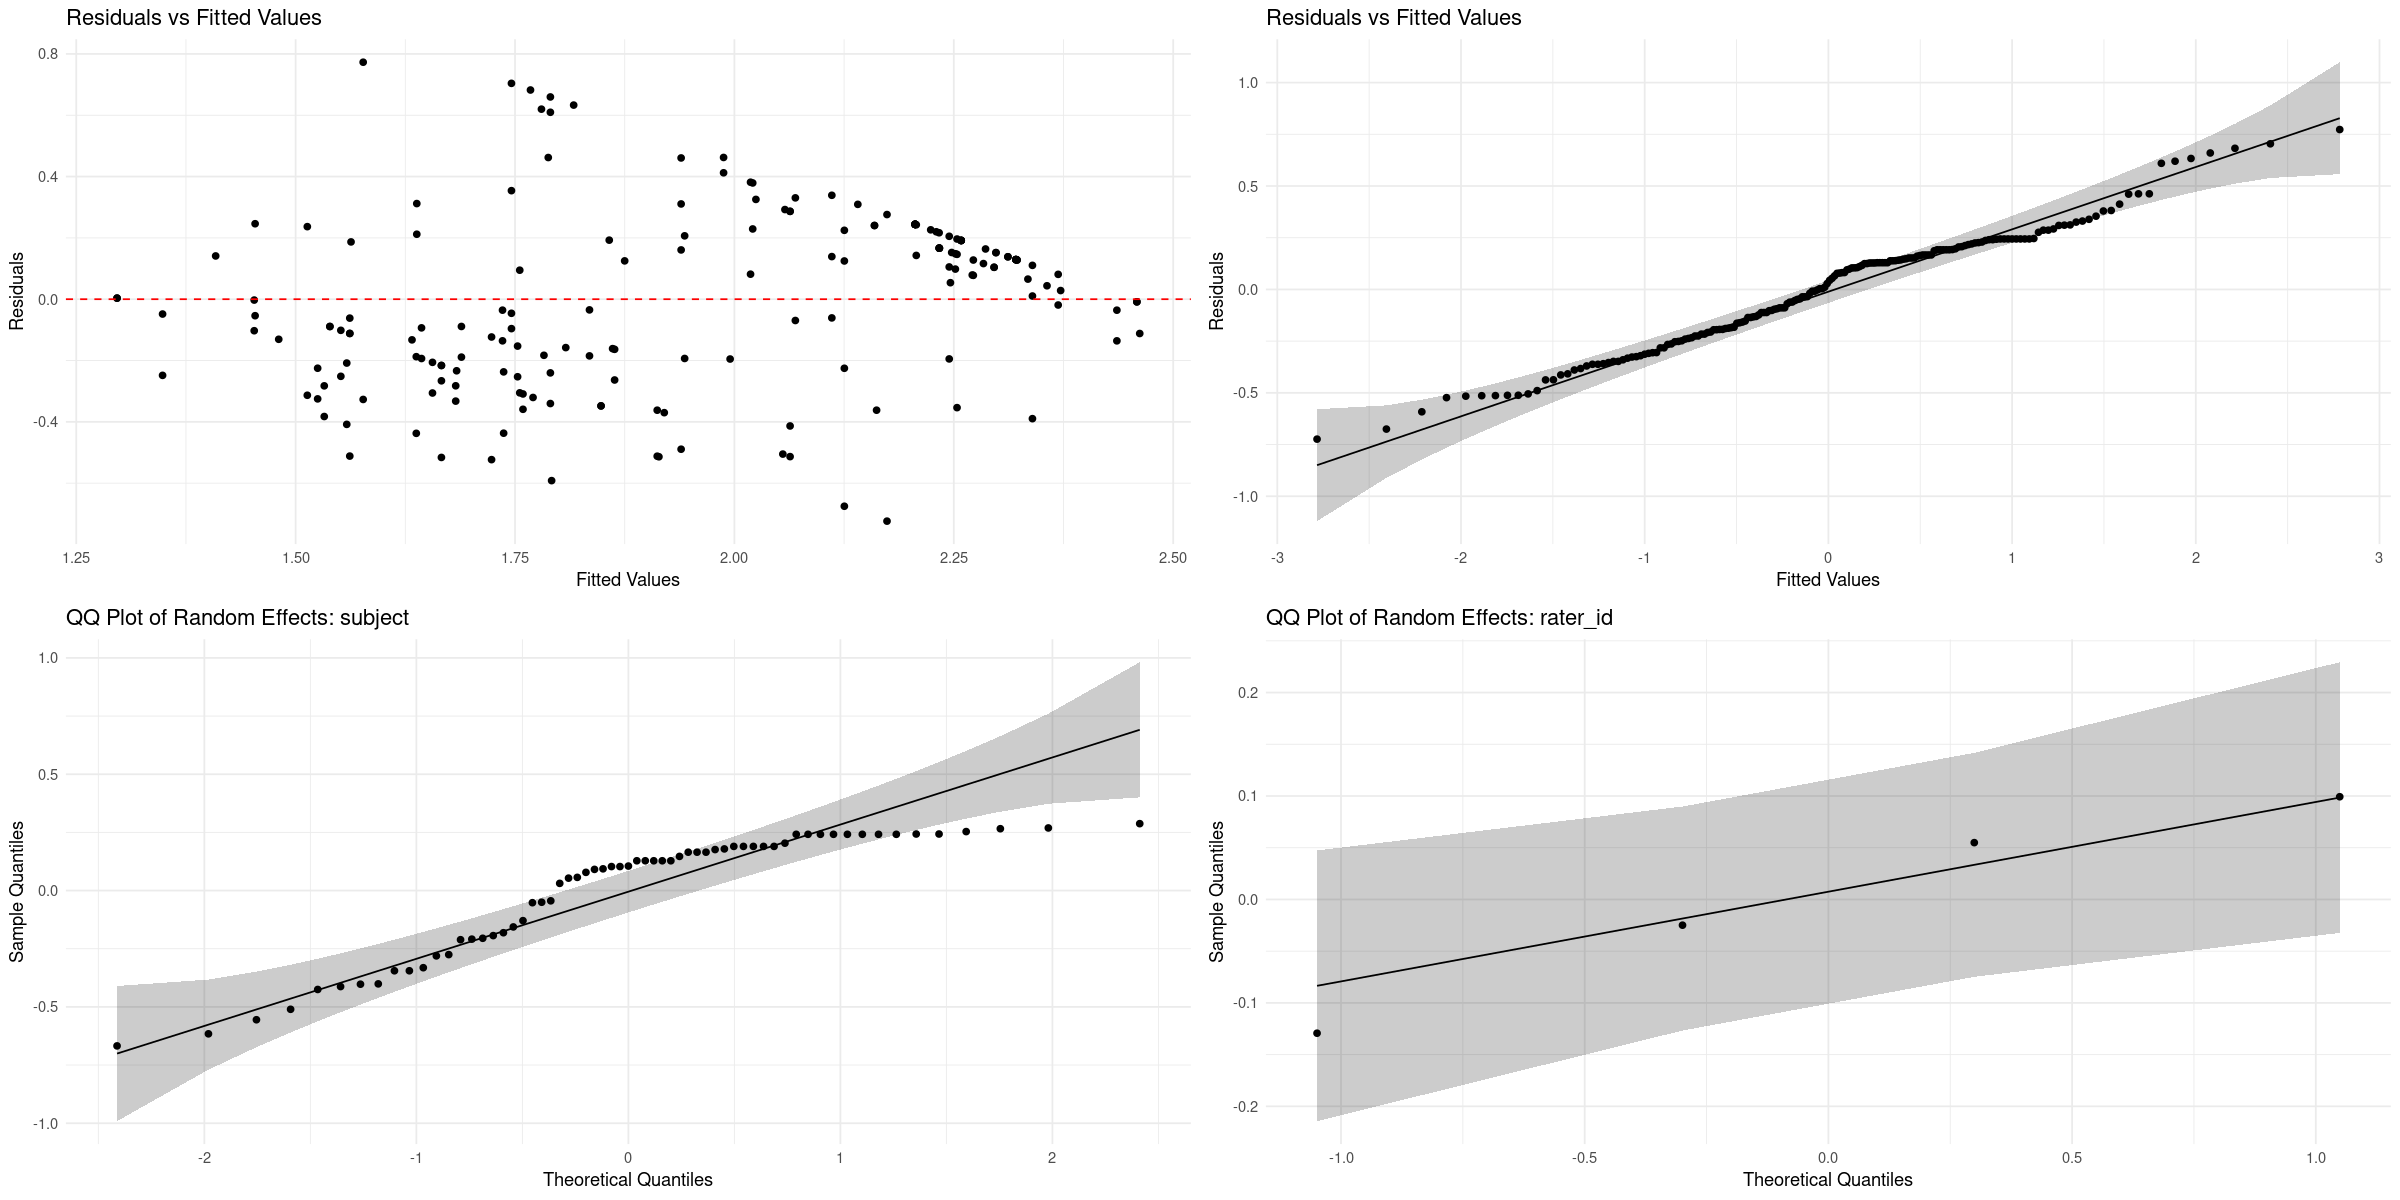

In [114]:
## Fit model without defaced as random effect
library(lme4)
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=df_poor)
summary(fm0)
ranef(fm0)
suppressWarnings(visualize_lmer_fit(fm0))

Linear mixed model fit by REML ['lmerMod']
Formula: 
as.numeric(rating) ~ (1 | subject) + (1 | rater_id) + (1 | defaced:rater_id)
   Data: df_poor

REML criterion at convergence: 189.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.18138 -0.58629  0.04847  0.60643  2.22592 

Random effects:
 Groups           Name        Variance Std.Dev.
 subject          (Intercept) 0.11031  0.33212 
 defaced:rater_id (Intercept) 0.01309  0.11441 
 rater_id         (Intercept) 0.00820  0.09056 
 Residual                     0.09824  0.31344 
Number of obs: 186, groups:  subject, 63; defaced:rater_id, 8; rater_id, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.10236    0.08067   26.06

$subject
    (Intercept)
15   0.27823756
34   0.16570673
48   0.21335570
72   0.13717498
80   0.25287478
94   0.12236238
102 -0.43374908
104  0.06872454
105  0.04227856
146  0.25977057
165  0.16570673
167 -0.17484760
168  0.25287478
175 -0.57315196
176  0.17769602
204 -0.63200166
206  0.11873699
212  0.17769602
216  0.23983493
226 -0.52514779
252 -0.38846165
256  0.17769602
257 -0.28855101
258 -0.17026091
261 -0.01451903
267  0.25287478
274  0.24396073
277  0.11119810
282  0.25287478
295 -0.23581583
313  0.26524721
316 -0.41173270
329 -0.10100487
338  0.28722739
353  0.13636237
357  0.25287478
383 -0.04938248
384  0.13926075
385  0.23983493
386  0.13926075
387 -0.45051615
437  0.25977057
443 -0.14035404
448 -0.68283870
481 -0.19670689
482 -0.32477761
524 -0.33433466
525  0.17769602
538  0.21934769
544  0.24952148
565  0.25287478
568  0.21338895
577 -0.21583395
598  0.06033403
599 -0.21821031
603  0.25120504
605 -0.28739898
612  0.04227856
632  0.09835808
633  0.12480406
634 -0.02368332

TableGrob (2 x 2) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]


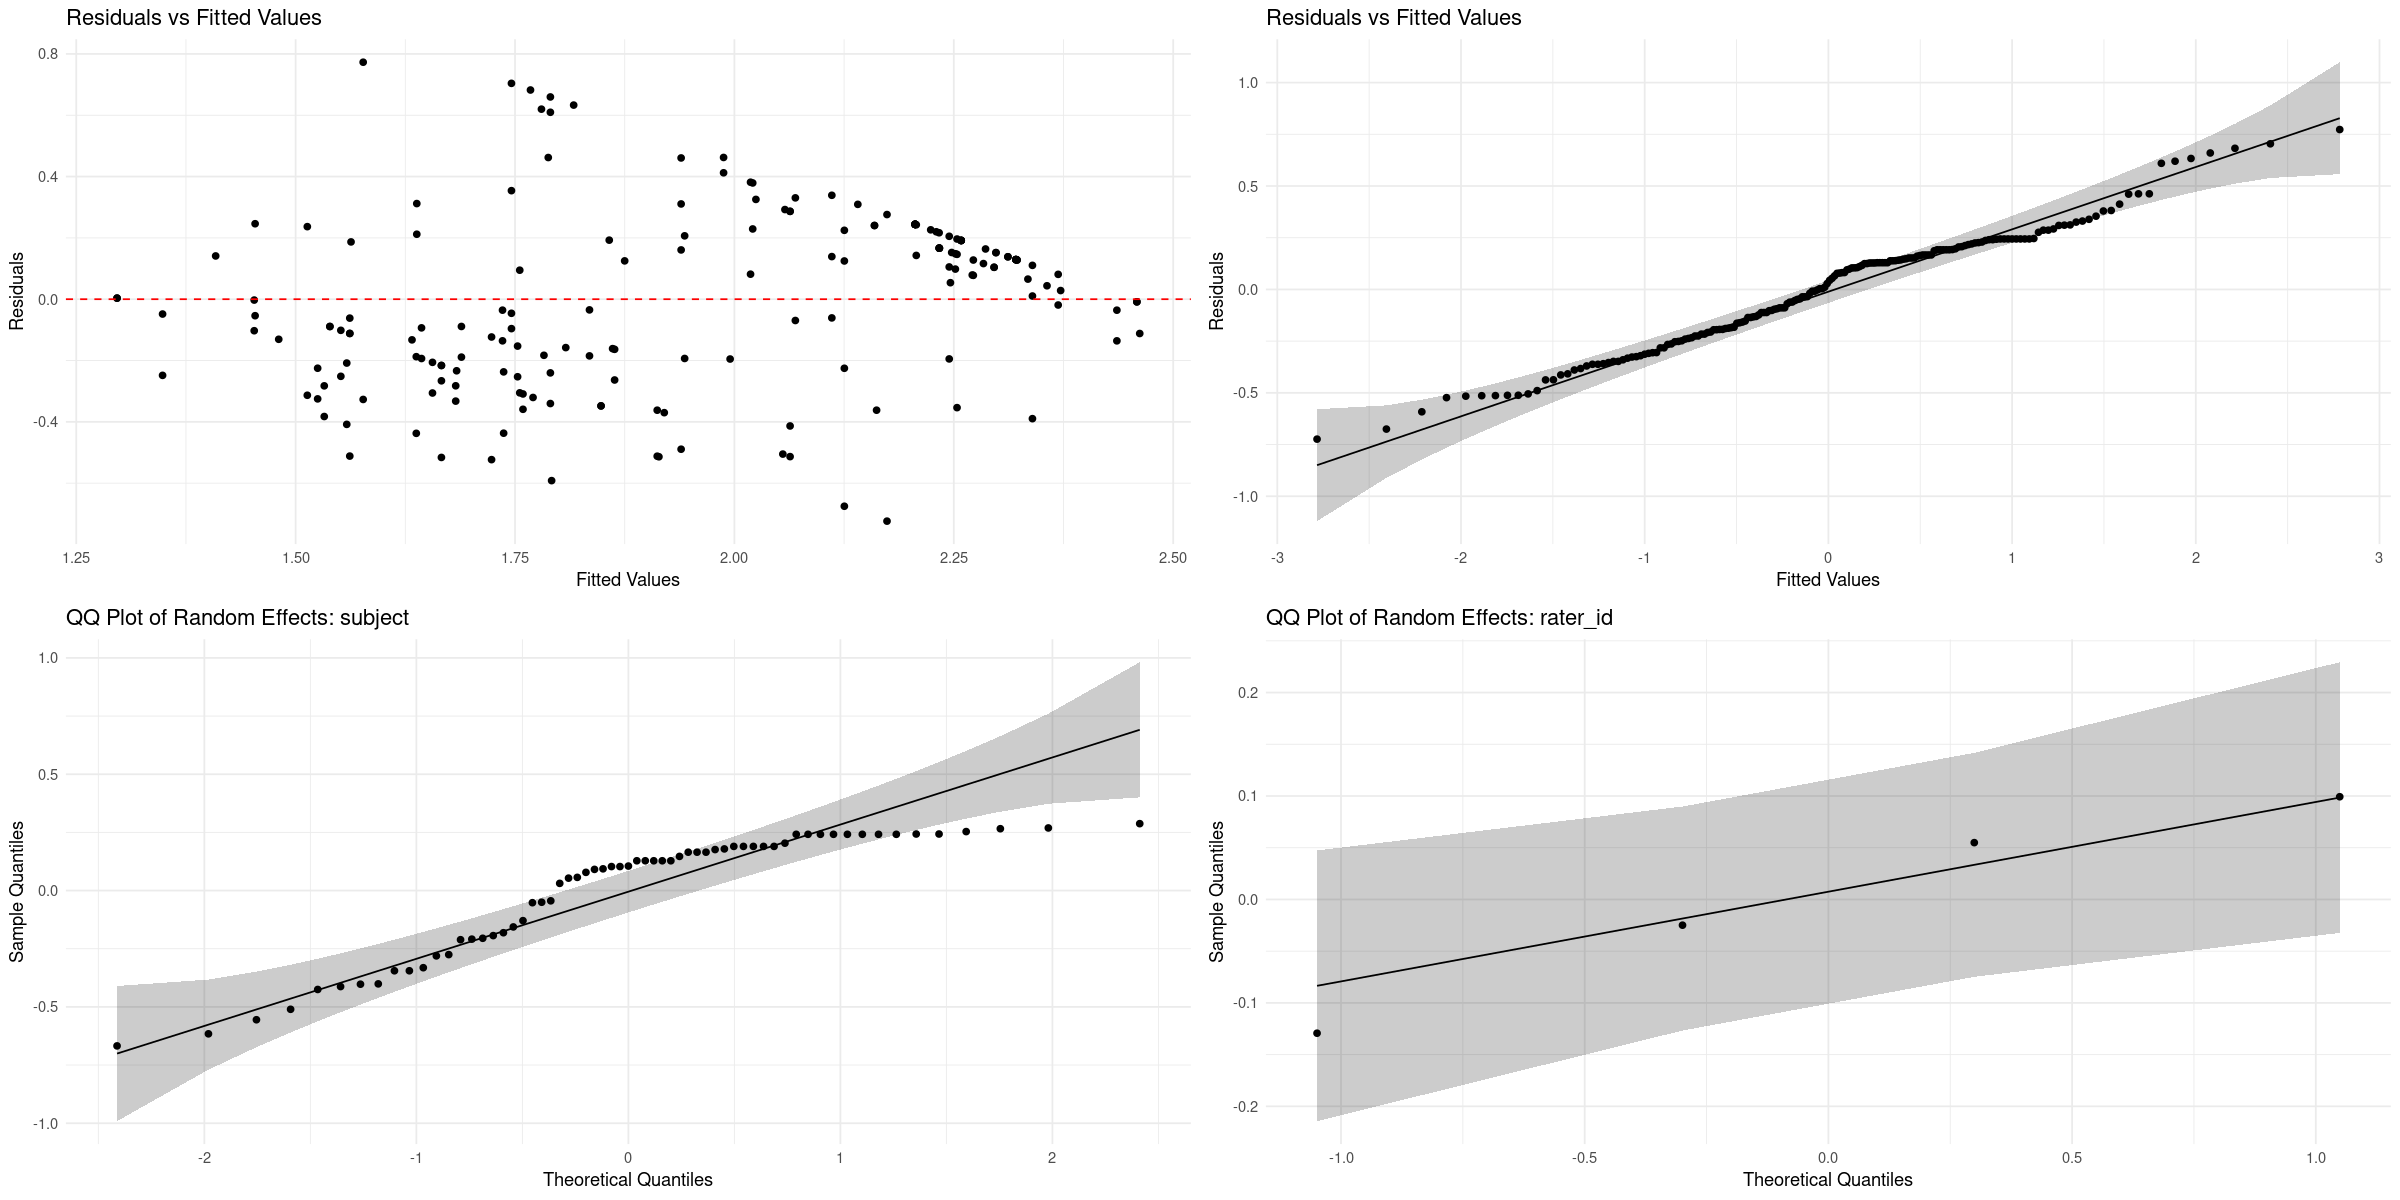

In [115]:
## Fit model with defaced as random effect
library(lme4)
fm1 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id) + (1| defaced:rater_id), data=df_poor)
summary(fm1)
ranef(fm1)
suppressWarnings(visualize_lmer_fit(fm0))

In [116]:
#Likelihood-ratio test
anova(fm0, fm1)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,198.5114,211.4144,-95.25569,190.5114,NA,NA,NA
fm1,5,196.1171,212.2458,-93.05856,186.1171,4.394269,1,0.03605992


## Sanity check with simulated data

We verify that the model selected is able to detect differences when a bias has been manually introduced in simulated data and vice versa that the model does not detect differences when no bias was introduced. The simulated data were generated by running `../../data/simulate_data.R`

In [117]:
library(lme4)
# Load simulated data
simulated_df <- readRDS(("../../data/simulated_normal_ratings.rds"))

#Fit the models
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=simulated_df)
fm1 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id) + (1| defaced:rater_id), data=simulated_df)

#Likelihood-ratio test
anova(fm0, fm1)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,11136.61,11157.81,-5564.305,11128.61,NA,NA,NA
fm1,5,11080.29,11106.79,-5535.145,11070.29,58.31997,1,2.227708e-14


All good, we see that the simulated bias is detected by our linear mixed-effects model.

In [118]:
library(lme4)
# Load the simulated data without bias
simulated_df_no_bias <- readRDS(("../../data/simulated_normal_nobias_ratings.rds"))

#Fit the models
fm0 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id), data=simulated_df_no_bias)
fm1 <- lmer(as.numeric(rating) ~ (1 | subject) + (1 | rater_id) + (1| defaced:rater_id), data=simulated_df_no_bias)

#Likelihood-ratio test
anova(fm0, fm1)

boundary (singular) fit: see help('isSingular')

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fm0,4,10937.58,10958.78,-5464.792,10929.58,NA,NA,NA
fm1,5,10939.58,10966.08,-5464.792,10929.58,3.637979e-12,1,0.9999985


We also verified that no bias is found by our models when it is not introduced in the simulated data.